<a href="https://colab.research.google.com/github/sadnyd/LLMEmpKnowlegdeGraph/blob/main/IBMInsights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/My Drive/dataset'

In [ ]:
df = pd.read_csv(f'{dataset_path}/train.csv')
print(df.head())

   enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
1        29725   city_40                   0.776   Male   
2        11561   city_21                   0.624    NaN   
3        33241  city_115                   0.789    NaN   
4          666  city_162                   0.767   Male   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1   No relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   
3   No relevent experience                 NaN        Graduate   
4  Has relevent experience       no_enrollment         Masters   

  major_discipline experience company_size    company_type last_new_job  \
0             STEM        >20          NaN             NaN            1   
1             STEM         15        50-99         Pvt Ltd           >4   
2             STEM     

In [ ]:
# Class distribution visualization
labels = df['target'].value_counts()
fig = px.pie(values=labels.values, names=labels.index, width=400, height=400)
fig.update_layout(title="Class Label Distribution", title_x=0.5)
fig.show()

In [ ]:
# Data types of columns
print(df.dtypes)

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object


In [ ]:
# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(exclude=object).columns
categorical_cols = df.select_dtypes(include=object).columns

In [ ]:
# Missing values check and handling
def fill_missing_values(X):
    X = X.copy()
    X['gender'] = X['gender'].fillna('Male')
    X['enrolled_university'] = X['enrolled_university'].fillna('no_enrollment')
    X['education_level'] = X['education_level'].fillna('Graduate')
    X['major_discipline'] = X['major_discipline'].fillna('STEM')
    X['experience'] = X['experience'].fillna('>20')
    X['company_size'] = X['company_size'].fillna('50-99')
    X['company_type'] = X['company_type'].fillna('Pvt Ltd')
    X['last_new_job'] = X['last_new_job'].fillna('1')

    return X

In [ ]:
fill_missing_values(df)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,50-99,Pvt Ltd,never,83,0.0
3,33241,city_115,0.789,Male,No relevent experience,no_enrollment,Graduate,Business Degree,<1,50-99,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,50-99,Pvt Ltd,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,STEM,<1,500-999,Pvt Ltd,2,97,0.0


In [ ]:
# Splitting features and labels
y = df['target']
X = df.drop(columns=['enrollee_id', 'target'])

In [ ]:
# Ensure the directory exists
os.makedirs('./saved', exist_ok=True)

# Save the categorical columns as needed if the file doesn't already exist
if not os.path.exists('./saved/one_hot_cols.npy'):
    # Assuming `categorical_cols` is already defined
    np.save('./saved/one_hot_cols.npy', categorical_cols)


In [ ]:
# Preprocessing categorical features
def pre_process_data(X, categorical_cols, mode='train'):
    if mode == 'train':
        one_hot_cols = []
        label_enc_cols = []
        label_encoders = dict()
        for col in categorical_cols:
            if X[col].unique().shape[0] <= 5:
                label_enc_cols.append(col)
                le = preprocessing.LabelEncoder()
                le.fit(X[col])
                X[col] = le.transform(X[col])
                label_encoders[col] = le
            else:
                one_hot_cols.append(col)
        np.save('./saved/one_hot_cols.npy', one_hot_cols)
        np.save('./saved/label_enc_cols.npy', label_enc_cols)
        np.save('./saved/label_encoders.npy', label_encoders)
        X = pd.get_dummies(X, columns=one_hot_cols)
        np.save('./saved/dummies_columns.npy', X.columns)
        return X
    elif mode == 'test':
        one_hot_cols = np.load('./saved/one_hot_cols.npy', allow_pickle=True)
        label_enc_cols = np.load('./saved/label_enc_cols.npy', allow_pickle=True)
        label_encoders = np.load('./saved/label_encoders.npy', allow_pickle=True).tolist()
        for col in label_enc_cols:
            X[col] = label_encoders[col].transform(X[col])
        X = pd.get_dummies(X, columns=one_hot_cols)
        dummies_columns = np.load('./saved/dummies_columns.npy', allow_pickle=True)
        X = X.reindex(columns=dummies_columns, fill_value=0)
        return X

In [ ]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
X = pre_process_data(X, categorical_cols)
print(X.shape)

(19158, 181)


In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Training data:", X_train.shape)
print("Testing data:", X_test.shape)

Training data: (14368, 181)
Testing data: (4790, 181)


In [ ]:
# Normalization
norm = MinMaxScaler()
X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

In [ ]:
# Model Training and Evaluation

# Gaussian Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

Confusion Matrix


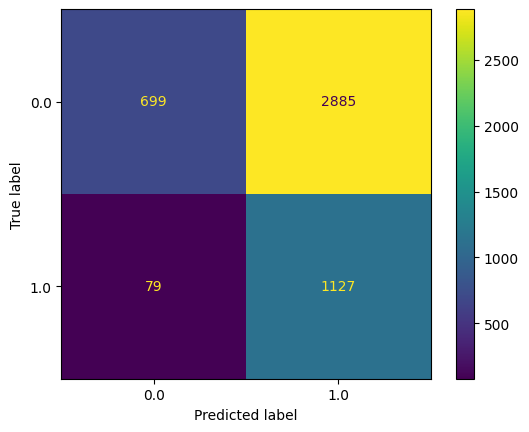

Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.20      0.32      3584
         1.0       0.28      0.93      0.43      1206

    accuracy                           0.38      4790
   macro avg       0.59      0.56      0.38      4790
weighted avg       0.74      0.38      0.35      4790



In [ ]:
# Confusion Matrix Display
print('\033[1m' + 'Confusion Matrix' + '\033[0m')
ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)
plt.show()

print('\033[1m' + 'Classification Report' + '\033[0m')
print(classification_report(y_test, y_pred))

The Area under the curve ROC: 0.588835722799692


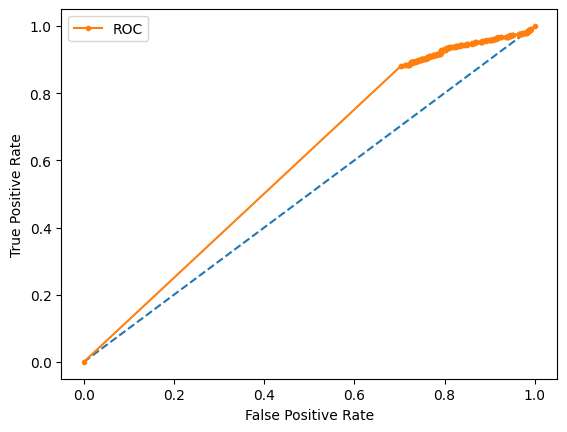

In [ ]:
# ROC Curve for Naive Bayes
plt.plot([0, 1], [0, 1], linestyle='--')
yhat = classifier.predict_proba(X_test)
pos_probs = yhat[:, 1]
fpr, tpr, _ = roc_curve(y_test, pos_probs)
plt.plot(fpr, tpr, marker='.', label='ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
print('\033[1m' + 'The Area under the curve ROC:' + '\033[0m', roc_auc_score(y_test, pos_probs))
plt.show()

The Area under the PR Curve: 0.6033675118499969


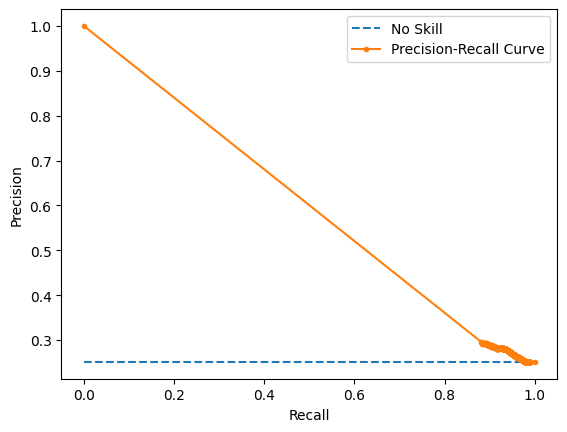

In [ ]:
# Precision-Recall Curve for Naive Bayes
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
pyplot.plot(recall, precision, marker='.', label='Precision-Recall Curve')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
print('\033[1m' + 'The Area under the PR Curve:' + '\033[0m', auc(recall, precision))
pyplot.show()

In [ ]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, criterion='entropy')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

Confusion Matrix


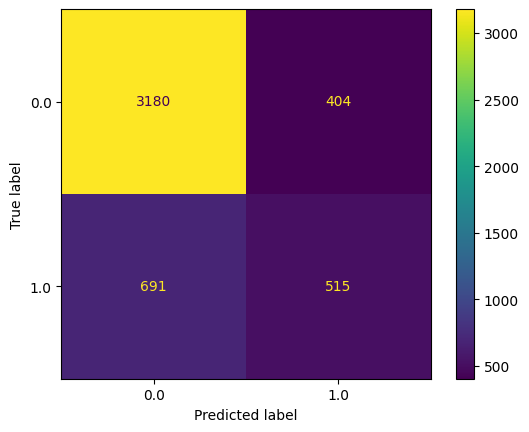

In [ ]:
# Confusion Matrix Display for Random Forest
print('\033[1m' + 'Confusion Matrix' + '\033[0m')
ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)
plt.show()

In [ ]:
print('\033[1m' + 'Classification Report' + '\033[0m')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85      3584
         1.0       0.56      0.43      0.48      1206

    accuracy                           0.77      4790
   macro avg       0.69      0.66      0.67      4790
weighted avg       0.76      0.77      0.76      4790



The Area under the curve ROC: 0.7759069005789504


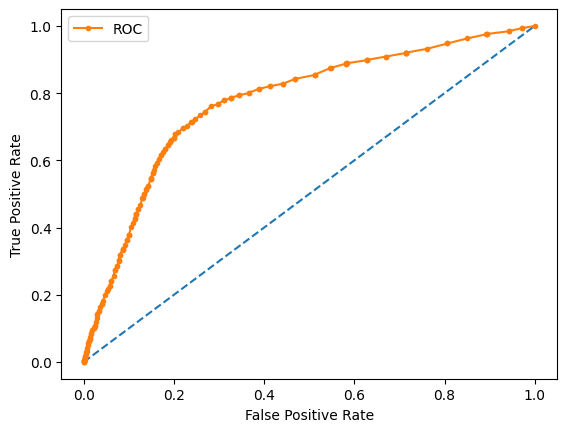

In [ ]:
# ROC Curve for Random Forest
plt.plot([0, 1], [0, 1], linestyle='--')
yhat = classifier.predict_proba(X_test)
pos_probs = yhat[:, 1]
fpr, tpr, _ = roc_curve(y_test, pos_probs)
plt.plot(fpr, tpr, marker='.', label='ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
print('\033[1m' + 'The Area under the curve ROC:' + '\033[0m', roc_auc_score(y_test, pos_probs))
plt.show()

The Area under the PR Curve: 0.5164849751782543


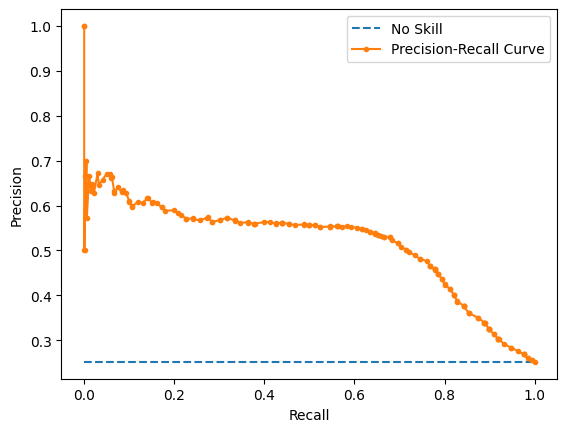

In [ ]:
# Precision-Recall Curve for Random Forest
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
pyplot.plot(recall, precision, marker='.', label='Precision-Recall Curve')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
print('\033[1m' + 'The Area under the PR Curve:' + '\033[0m', auc(recall, precision))
pyplot.show()